In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Import required libraries

import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import loadmat
from pathlib import Path
from PIL import Image
import random
from torch.utils.data import ConcatDataset, Subset

In [2]:
root_dir = Path(r'C:\Users\tomersp10\Desktop\PythonProject\cars196\Stanford Cars Dataset')

cars_annos = root_dir / 'cars_annos.mat'
cars_test = root_dir / 'cars_test' / 'cars_test'
cars_train = root_dir / 'cars_train' / 'cars_train'

cars_annos_mat = loadmat(cars_annos)
training_images = os.listdir(cars_train)
testing_images = os.listdir(cars_test)


In [3]:
# This array will be 0-indexed; we will have to remember that whenever we use it
class_names = [arr[0] for arr in cars_annos_mat['class_names'][0]]

# A bunch of weird indexing will happen because of how nested these annotation arrays are
sample1 = cars_annos_mat['annotations'][0][0]
sample1_path, sample1_class_name, sample1_test = sample1[0][0].split("/")[-1], sample1[5][0][0], sample1[6][0][0]

In [4]:
root_dir = Path(r'C:\Users\tomersp10\Desktop\PythonProject\cars196\Standford_cars_dataset_meta')

cars_annos_train = root_dir / "devkit" / "cars_train_annos.mat"
cars_annos_test = root_dir / "cars_test_annos_withlabels (1).mat"

cars_meta_mat = loadmat(root_dir / "devkit" / "cars_meta.mat")
cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test)

class_names = [arr[0] for arr in cars_meta_mat['class_names'][0]]


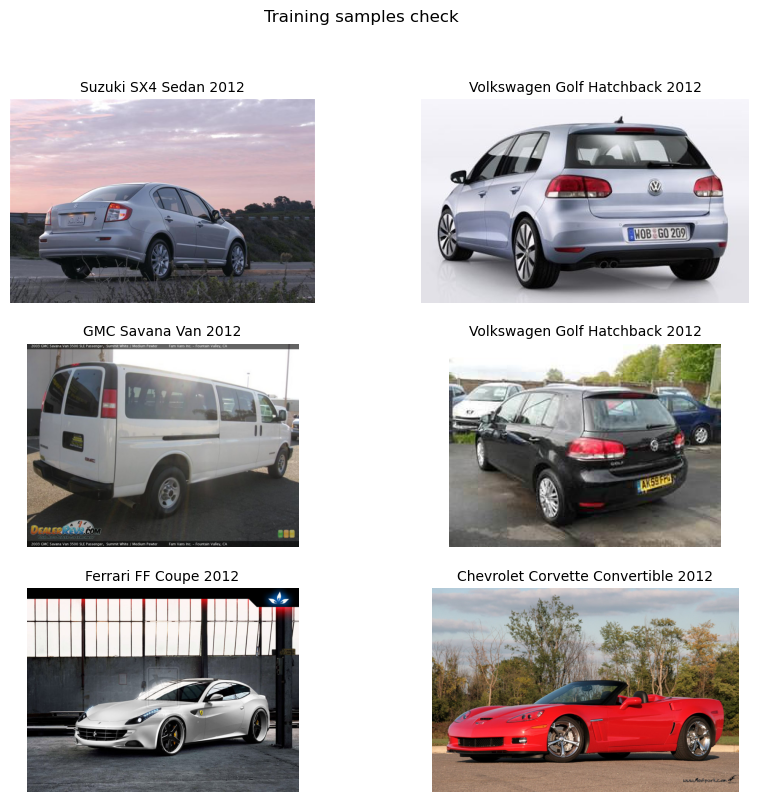

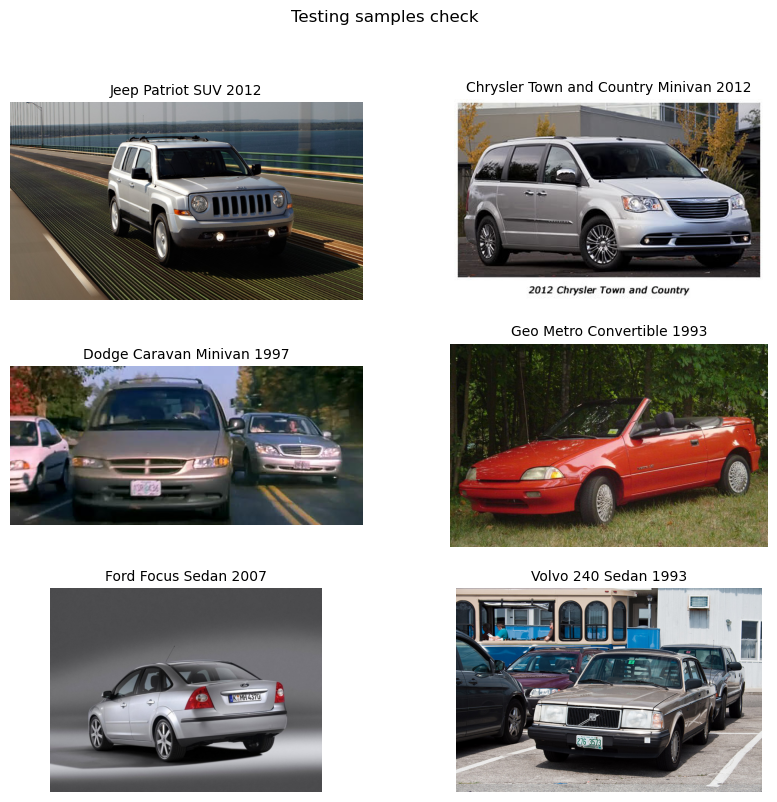

In [5]:
sample1 = cars_annos_train_mat['annotations'][0][0]
sample1_path, sample1_class = sample1[-1][0], sample1[-2][0][0] - 1

w, h = 2, 3
fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h)) 
fig.suptitle('Training samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_train_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_train, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h)) 
fig.suptitle('Testing samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_test_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_test, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

In [6]:
# הגדרת טרנספורמציות בסיסיות (ללא Augmentation)
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # שינוי גודל התמונות
    transforms.ToTensor(),  # המרת התמונה ל-Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # נרמול
])


In [7]:
# הגדרת DataSet מותאם אישית
class CarsDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.img_paths = [os.path.join(img_dir, sample[-1][0]) for sample in annotations[0]]
        self.labels = [sample[-2][0][0] - 1 for sample in annotations[0]]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")  # להבטיח שהתמונה ב-RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label


# יצירת מערכי נתונים
train_dataset = CarsDataset(cars_annos_train_mat['annotations'], cars_train, transform=basic_transforms)
test_dataset = CarsDataset(cars_annos_test_mat['annotations'], cars_test, transform=basic_transforms)


In [8]:
print(train_dataset[0])


(tensor([[[-0.4911, -0.6109, -0.7308,  ...,  2.1633,  2.1462,  2.1804],
         [-0.6281, -0.6109, -0.7137,  ...,  2.1290,  2.1290,  2.1633],
         [-0.6965, -0.7650, -0.7137,  ...,  2.0777,  2.0948,  2.1462],
         ...,
         [ 0.8789,  0.8789,  0.8104,  ..., -0.6109, -0.6452, -0.6109],
         [ 0.7933,  0.7591,  0.7077,  ..., -0.9534, -0.9705, -0.9877],
         [ 0.6221,  0.7419,  0.8104,  ..., -1.1075, -1.1589, -1.1247]],

        [[-0.0574, -0.1800, -0.3025,  ...,  2.4286,  2.4286,  2.4286],
         [-0.1975, -0.1800, -0.2850,  ...,  2.4111,  2.4111,  2.4286],
         [-0.2675, -0.3375, -0.2850,  ...,  2.3585,  2.3761,  2.4111],
         ...,
         [ 1.0630,  1.0455,  0.9755,  ..., -0.3200, -0.3550, -0.3200],
         [ 0.9930,  0.9405,  0.8529,  ..., -0.6352, -0.6527, -0.6527],
         [ 0.8179,  0.9230,  0.9755,  ..., -0.7402, -0.7927, -0.7752]],

        [[ 0.2348,  0.1128, -0.0092,  ...,  2.6400,  2.6400,  2.6400],
         [ 0.0953,  0.1128,  0.0082,  ...,  

In [9]:
print(test_dataset[0])

(tensor([[[2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         ...,
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318]],

        [[2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         ...,
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111],
         [2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.4111, 2.4111]],

        [[2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6226, 2.6226],
         [2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6226, 2.6226],
         [2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6226, 2

In [10]:
full_dataset = ConcatDataset([train_dataset, test_dataset])

In [11]:
# שמירת הדאטהסט בפורמט PyTorch
torch.save(full_dataset, "cars196_dataset.pt")

print("DataSet saved successfully as 'cars196_dataset.pt'")


DataSet saved successfully as 'cars196_dataset.pt'
